--- 
    Autores: Carlos Francisco Orejuela Lluncor<carlos.f.olluncor@udc.es>; Hugo Varela Sanchéz <hugo.varela.sanchez@udc.es>
    Asignatura: Modelización Estadística de Datos de Alta Dimensión
    Curso: 2024/2025
---

# Análisis del suelo de sotobosques de pinos

Descripción de las variables del conjunto de datos:
* Contenido en ppm de diferentes elementos químicos en el suelo de una parcela: N, P, K, Ca, Mg, S, Al, Fe, Mn, Zn, Mo
* Baresoil (Categorica): Cubierta de suelo desnudo (Low, High). Representa la zona que carece de vegetación en una parcela.
* Humdepth: grosor de la capa de humus (cm).
* pH (Categorica): pH del suelo (Low, Med, High)

Objetivo principal de esta práctica:
* Agrupar las parcelas con aquellas con características similares (Clustering)

In [117]:
library(ggplot2)
library(patchwork)
library(GGally)
library(scatterplot3d)
library(repr)

In [118]:
# Cargamos los datos
load("vegetal.RData")
df_vegetal <- vegetal

In [119]:
# Un vistazo a la estructura
head(df_vegetal, 2)

,N,P,K,Ca,Mg,S,Al,Fe,Mn,Zn,Mo,Baresoil,Humdepth,pH
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<dbl>,<fct>
1,22.3,47.4,165.9,436.1,64.3,42.3,316.5,200.1,28.2,7.2,0.3,Low,1.5,Med
2,31.1,32.3,73.7,219.0,52.5,25.5,304.6,204.4,14.2,2.6,0.5,Low,1.8,High


---
### Análisis exploratorio

#### Variables cuantitativas:

In [120]:
# Creacion de tabla de estadisticos para variables numericas:

stats_summary <- function(df){
    # Estadisticos a tener en cuenta
    cols <- c('Min.', '1st Qu.', 'Median', 'Mean', '3rd Qu.', 'Max.', 'Sd')
    stats_table <- c()
    for (i in 1:ncol(df)){
        # Agregar el estadistico de la desv. estandar
        colstats <- c( as.vector(summary(df[, i])), sd(df[, i]) )
        stats_table <- rbind(stats_table, colstats)
    }
    # Formatear tabla de estadisticos 
    stats_table <- data.frame(stats_table, row.names = colnames(df))
    colnames(stats_table) <- cols
    stats_table <- round(stats_table, 2)
    return(stats_table)
}

df_numeric <- df_vegetal[, c(1:11, 13)]
stats_table <- stats_summary(df_numeric)
stats_table

,Min.,1st Qu.,Median,Mean,3rd Qu.,Max.,Sd
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
N,13.40,18.83,22.05,22.38,26.30,33.1,5.53
P,22.70,32.60,41.50,45.08,57.05,73.5,14.95
K,43.60,127.15,166.60,162.93,205.75,313.8,64.84
Ca,188.50,425.72,518.50,569.66,739.25,1169.7,243.58
Mg,25.70,60.90,75.05,87.46,108.70,209.1,41.01
S,14.90,29.42,36.25,37.19,43.60,60.2,11.67
Al,12.10,38.20,106.80,142.48,233.72,435.1,122.32
Fe,2.30,5.58,27.80,49.61,85.15,204.4,60.45
Mn,10.10,26.70,36.55,49.33,59.00,132.0,33.91


A través de la tabla de estadísticos de las propiedades cuantitativas sobre el suelo de los sotobosques de pinos en esta muestra se obtiene lo siguiente:
1. En promedio, el elemento químico con mayor concentración en ppm sobre el suelo de las parcelas es el Calcio (Ca). Asimismo, en media se obtuvo que existen parcelas que pueden variar con respecto al centroide en 243.58 ppm, siendo esta el elemento químico con mayor variabilidad. Esto es un indicador que en la muestra tomada de sotobosques de pinos se tienen unas con una concentración de Calcio muy baja como muy alta.

In [121]:
ppm_mean <- stats_table[, "Mean"]
names(ppm_mean) <- colnames(df_numeric)
# Buscar la posicion del elemento quimico con menor y mayor concentracion en ppm
max_ppm <- which.max(ppm_mean)
print("Mayor concentracion en ppm:"); print(ppm_mean[max_ppm])

[1] "Mayor concentracion en ppm:"
    Ca 
569.66 


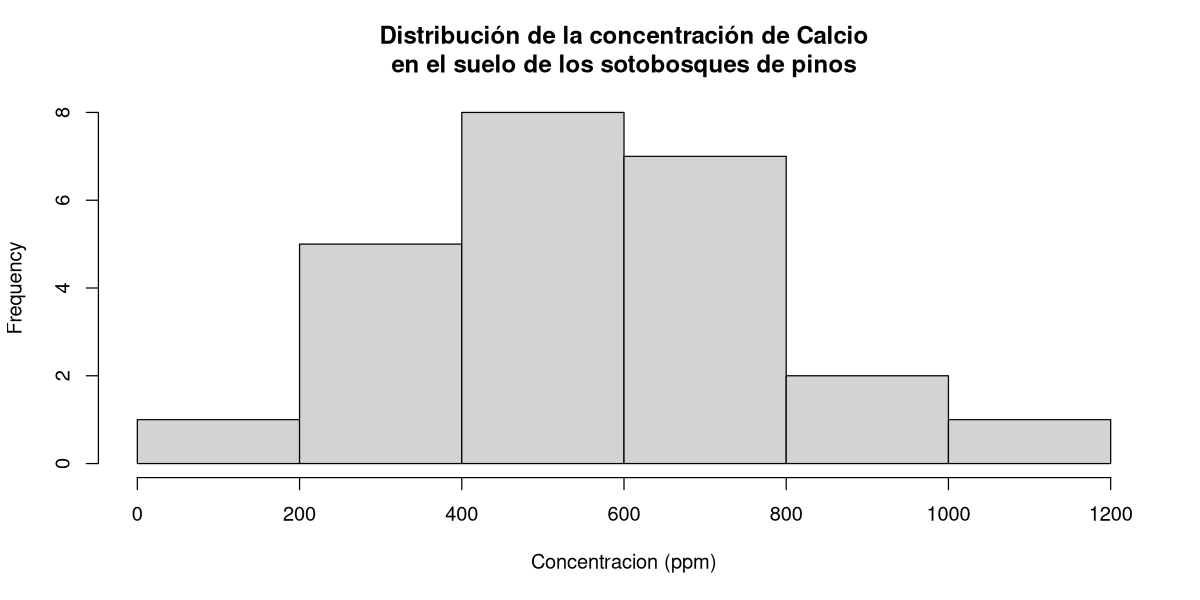

In [122]:
hist(df_numeric$Ca,
     xlab = "Concentracion (ppm)",
     main = "Distribución de la concentración de Calcio\nen el suelo de los sotobosques de pinos")

2. El Molidebno (Mo) es el caso opuesto del Calcio, porque es el elemento químico con menor concentración en ppm en el suelo de los sotobosques de pinos, así como el de menor variabilidad.

[1] "Menor concentracion en ppm:"
 Mo 
0.4 


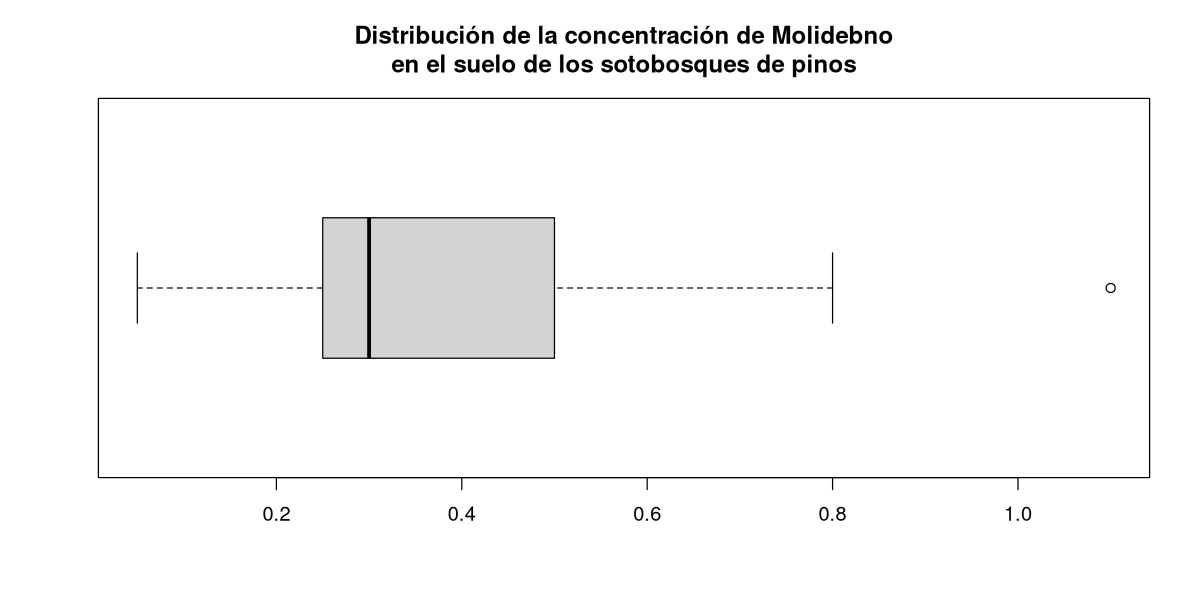

In [123]:
min_ppm <- which.min(ppm_mean)
print("Menor concentracion en ppm:"); print(ppm_mean[min_ppm])
# Distribucion
boxplot(df_numeric[, "Mo"],
        horizontal = T,
        main = "Distribución de la concentración de Molidebno\nen el suelo de los sotobosques de pinos")

In [124]:
# Se observa la presencia de un dato tipico en la muestra
outlier <- df_numeric[which.max(df_numeric$Mo), "Mo"]
sin_outlier <- df_numeric[df_numeric$Mo != outlier, "Mo"]
# Calcular en cuanto se increment la media de la concentracion de Molidebno en el suelo de las parcelas
pct <- round(stats_table["Mo", "Mean"]/mean(sin_outlier) - 1, 2)
cat("La media del Mo se incrementa en un", pct*100, "% (aprox.) debido a la presencia del outlier.")

La media del Mo se incrementa en un 10 % (aprox.) debido a la presencia del outlier.

3. El grosor de la capa de humus de esta muestra de sotobosques de pinos se encuentra entre 1 y 3 cm, aunque existe solo una observación cuyo valor para esta propiedad se encuentra más alejado de este rango.

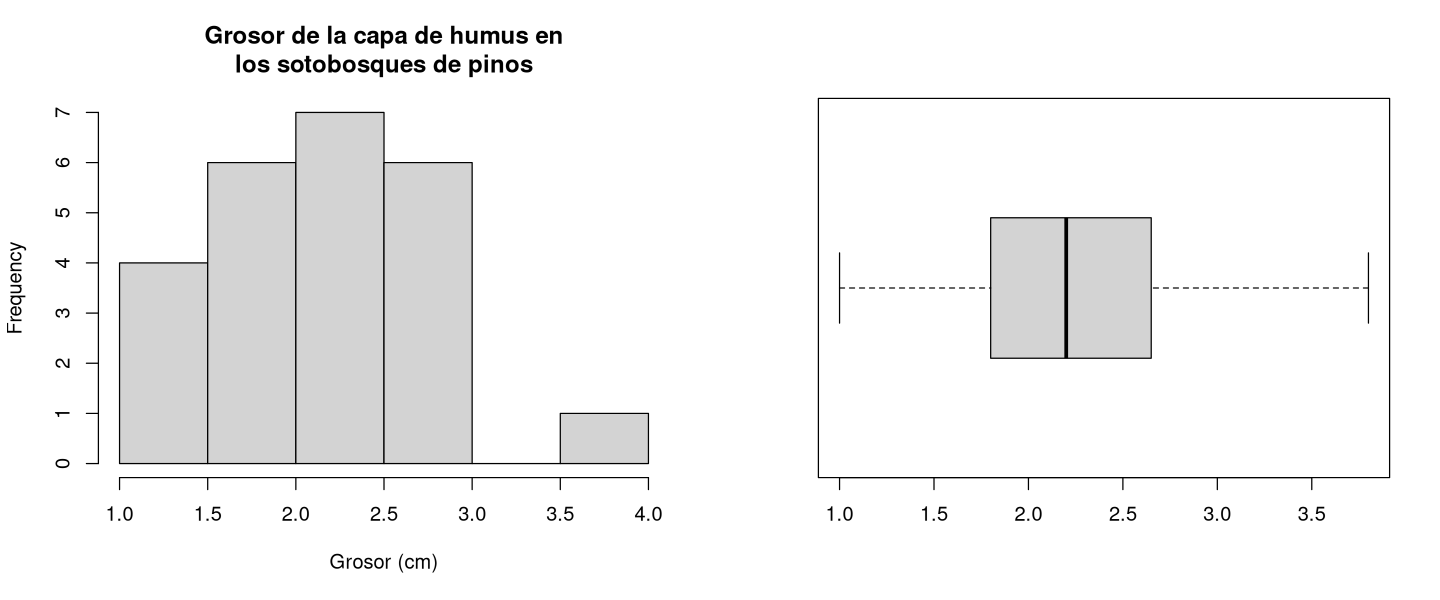

In [125]:
# Analizar el grosor de la capa de humus (cm)
options(repr.plot.width=12, repr.plot.height=5)
par(mfrow=c(1, 2))
hist(df_numeric$Humdepth, 
    xlab = "Grosor (cm)",
    main = "Grosor de la capa de humus en\nlos sotobosques de pinos")
boxplot(df_numeric$Humdepth, horizontal = T)

In [126]:
sum(df_numeric$Humdepth > 3)

[1] 1

4. Como se puede observar a través de la distribución del contenido medido en ppm de los diferentes elementos químicos:
   * El nitrógeno (N), Zinc (Zn) y Molidebno (Mo) son los que menos concentración tienen sobre el suelo de esta muestra de sotobosques de pinos.
   * Como se mencionó anteriormente, el Calcio (Ca) es con diferencia el elemento químico que mayor presencia tiene en suelo de estas 24 parcelas, siendo este superior a la mediana tanto del Potasio (K) como del Aluminio (Al), que son los otros 2 elementos químicos con mayor contenido en ppm que se pueden encontrar.
   * Por la asimetría de los boxplots del Calcio (Ca), Aluminio (Al) y Hierro (Fe), se observa que para esta muestra se han tomado tanto parcelas que tienen una gran concentración de estos elementos químicos sobre sus suelos, así como otras que cuentan con una cantidad más pequeña. Se tendría que analizar si existe alguna variable que cause que unas parcelas tengan un mayor contenido en ppm que otras sobre estos elemmentos.
   * Se tiene registro de datos atípicos tanto para el Magnesio (Mg), Manganeso (Mn), Zinc (Zn) y Molidebno (Mo). Y a través del análisis de los valores que toman para los elementos químicos que mayor concentración tienen sobre el suelo de una parcela se obtuvo que:
     * Aluminio: Las observaciones 22 y 23 son de aquellas parcelas con menor contenido tienen sobre este elemento; mientras que la 3 y 21 cuentan con una concentración mayor que el 50% de las datos, siendo esta primera (rowid 3) la parcela que mayor contenido de Aluminio en ppm tiene en la muestra.
     * Potasio: A excepción del dato atípico con rowid 22, se tiene que estas parcelas cuentan con un contenido de Potasio mayor a 166.6 ppm (Q2). 
     * Calcio: Cuentan con un contenido de Calcio mayor o igual a 518.5 ppm (Q2) aproximadamente (rowid 3).
     En un principio se esperaba que estos datos atípicos pertenezcan al grupo de parcelas con mayor concentración sobre estos elementos químicos. Sin embargo, este comportamiento no se pudo observar para el Aluminio.    

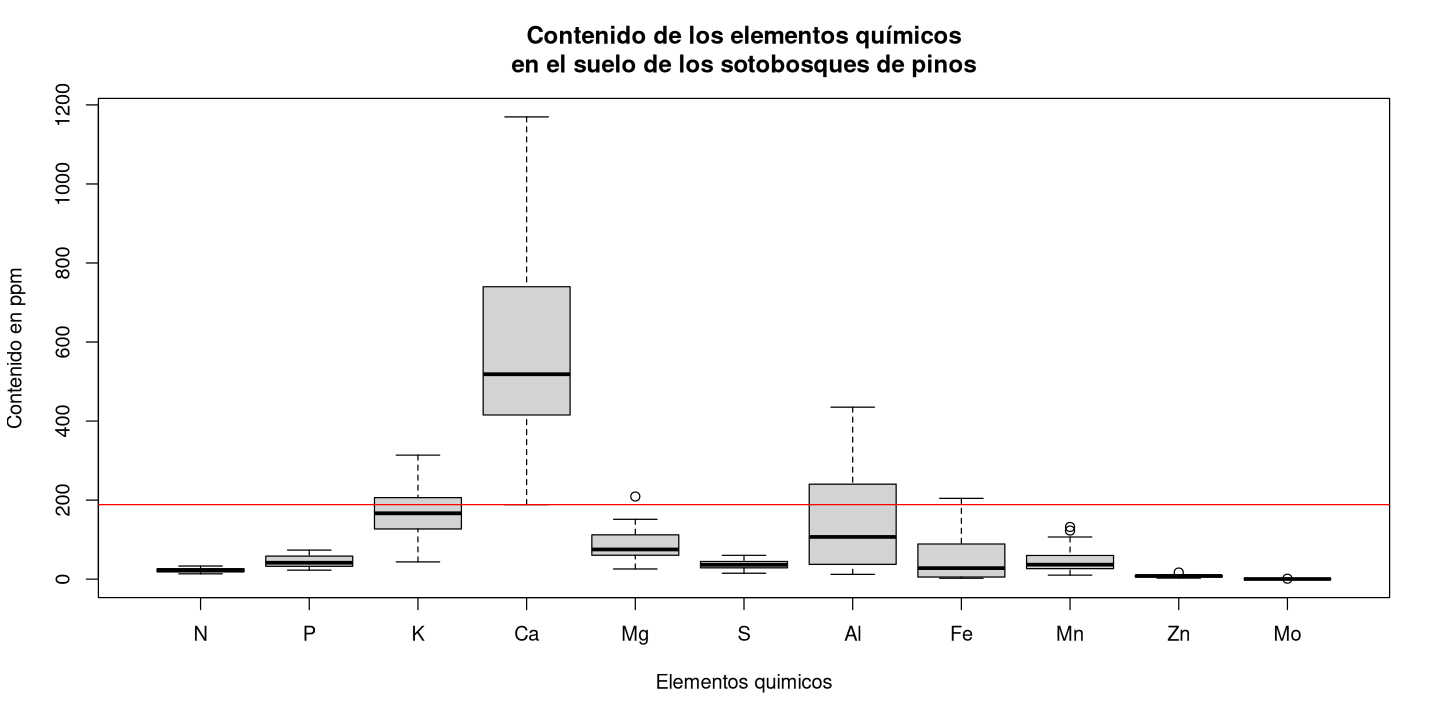

In [127]:
options(repr.plot.width=12, repr.plot.height=6)
boxplot(df_numeric[, 1:ncol(df_numeric) - 1],
       main = "Contenido de los elementos químicos\nen el suelo de los sotobosques de pinos",
       xlab = "Elementos quimicos", ylab = "Contenido en ppm")
abline(h=quantile(df_numeric$Ca, probs=c(0)), col = "red")

In [128]:
# Obtener los row ids de los datos atpicos
elementos <- c("Mg", "Mn", "Zn", "Mo")
outliers <- c()
for (i in 1:length(elementos)){
    data <- df_numeric[, elementos[i]]
    # Un dato se considera atipico si es > Q3 + 1.5*IQR | < Q1 - 1.5*IQR 
    cuartiles <- quantile(data, probs=c(0.25, 0.75))
    q1 <- cuartiles[1]; q3 <- cuartiles[2]
    IQR <- q3 - q1
    rowids <- which(data > q3 + IQR*1.5)
    outliers <- c(outliers, which(data > q3 + IQR*1.5))
    cat("Outliers para el", elementos[i], "->", rowids, "\n") 
}
table(outliers)

Outliers para el Mg -> 21 
Outliers para el Mn -> 22 23 
Outliers para el Zn -> 21 
Outliers para el Mo -> 3 


outliers
 3 21 22 23 
 1  2  1  1 

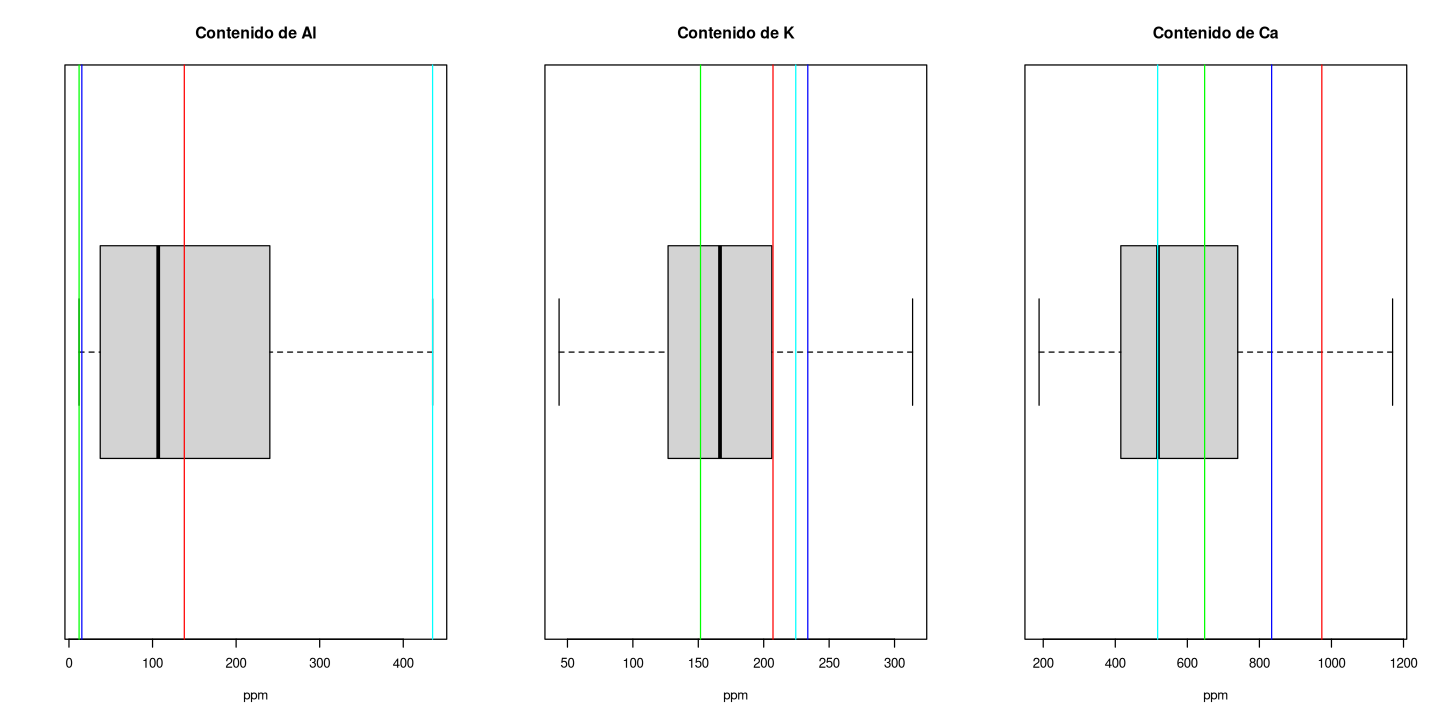

In [129]:
# Contenido en ppm de Aluminio, Potasio y Calcio de estos outliers
elementos <- c("Al", "K", "Ca")
par(mfrow=c(1, 3))
for (i in 1:length(elementos)){
    data <- df_numeric[, elementos[i]]
    title <- paste("Contenido de", elementos[i])
    boxplot(data, horizontal = T, main=title, xlab="ppm")
    abline( v=c(data[unique(outliers)]), col = c("red", "green", "blue", "cyan"))
}

Leyenda:
* red $\rightarrow$ 21
* green $\rightarrow$ 22
* blue $\rightarrow$ 23
* cyan $\rightarrow$ 3

---

#### Variables cualitativas:

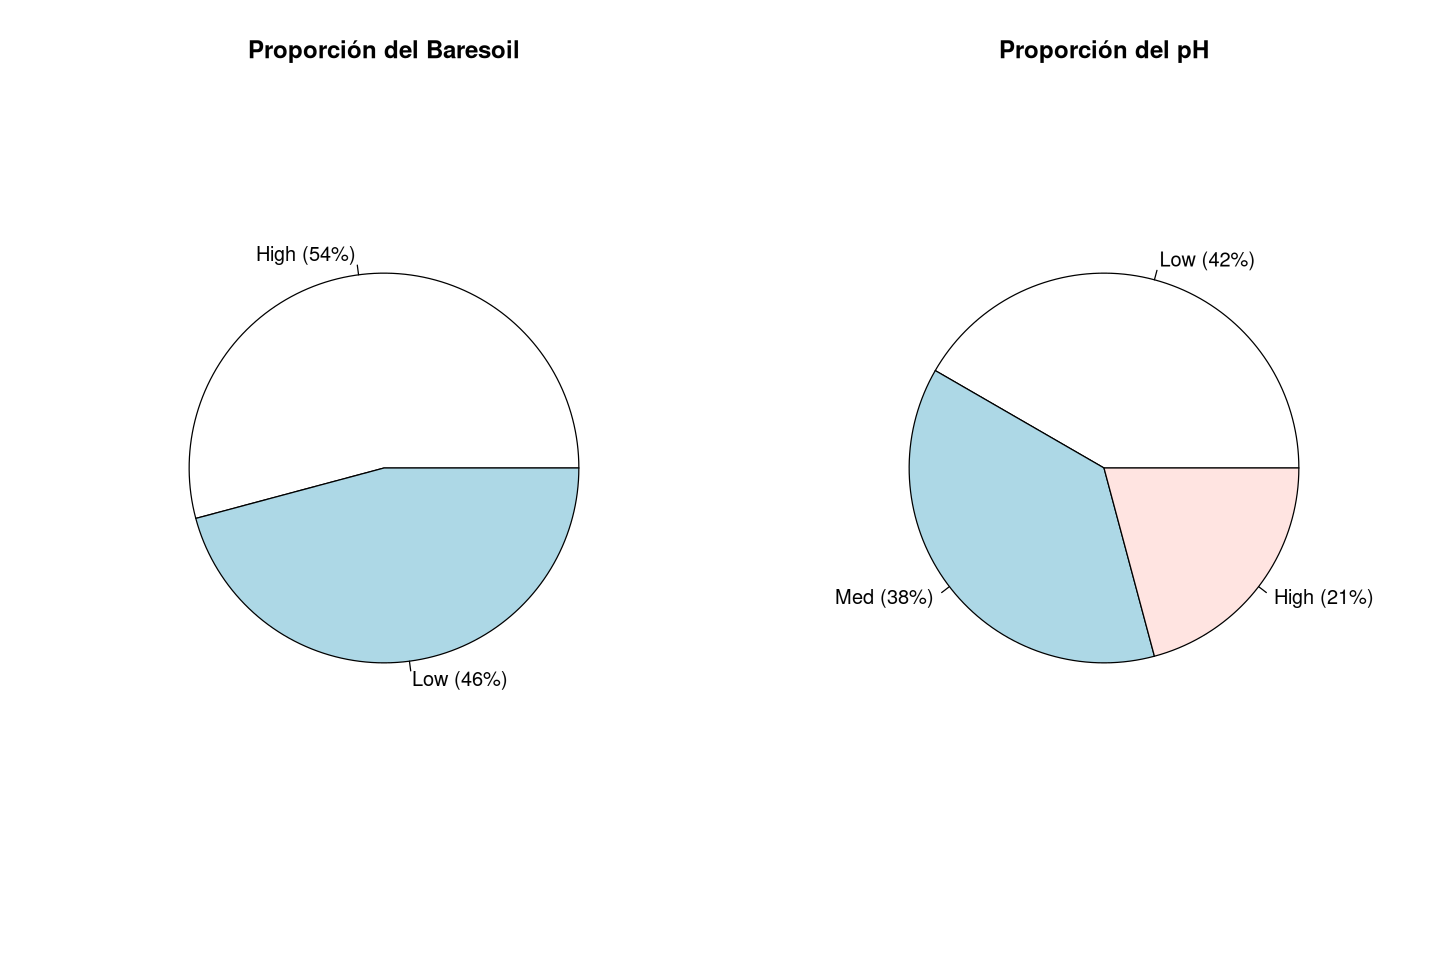

In [130]:
options(repr.plot.width=12, repr.plot.height=8)
par(mfrow=c(1, 2))
category_vars <- c("Baresoil", "pH")
for (i in 1:length(category_vars)){
 data <- df_vegetal[, category_vars[i]]
 # Calcular la proporcion para nivel de la variable categorica
 prop <- round(table(data)/nrow(df_vegetal), 2)
 labels <- c()
 # Definir las etiquetas para el pie chart: category (x%)
 for (j in 1:length(unique(data))){
     labels <- c(labels, paste0( names(prop[j]), " (", prop[j]*100, "%)"))
 }
 pie(table(data), 
     labels=labels, 
     radius=1.3, 
     main=paste("Proporción del", category_vars[i]))   
}

De la muestra de sotobosques de pinos se tiene que de manera aproximadamente proporcional se recogieron datos de parcelas con un nivel de suelo desnudo (Baresoil) tanto alto y bajo. Asimismo, se observa que el 80% de los registros son de parcelas que no poseen un pH alto, y la diferencia entre los porcentajes de parcelas con un pH bajo y medio no es significativamente grande.

---

#### Análisis multivariante

En primer lugar, se procede a estudiar la matriz de correlación entre las variables cuantitativas. Pero como se tiene un númer elevado de variables resulta más apropiado solo seleccionar aquellos que posee un coeficiente de correlación de Pearson significativo para evitar graficar una matriz de correlación que sea compleja de entender.

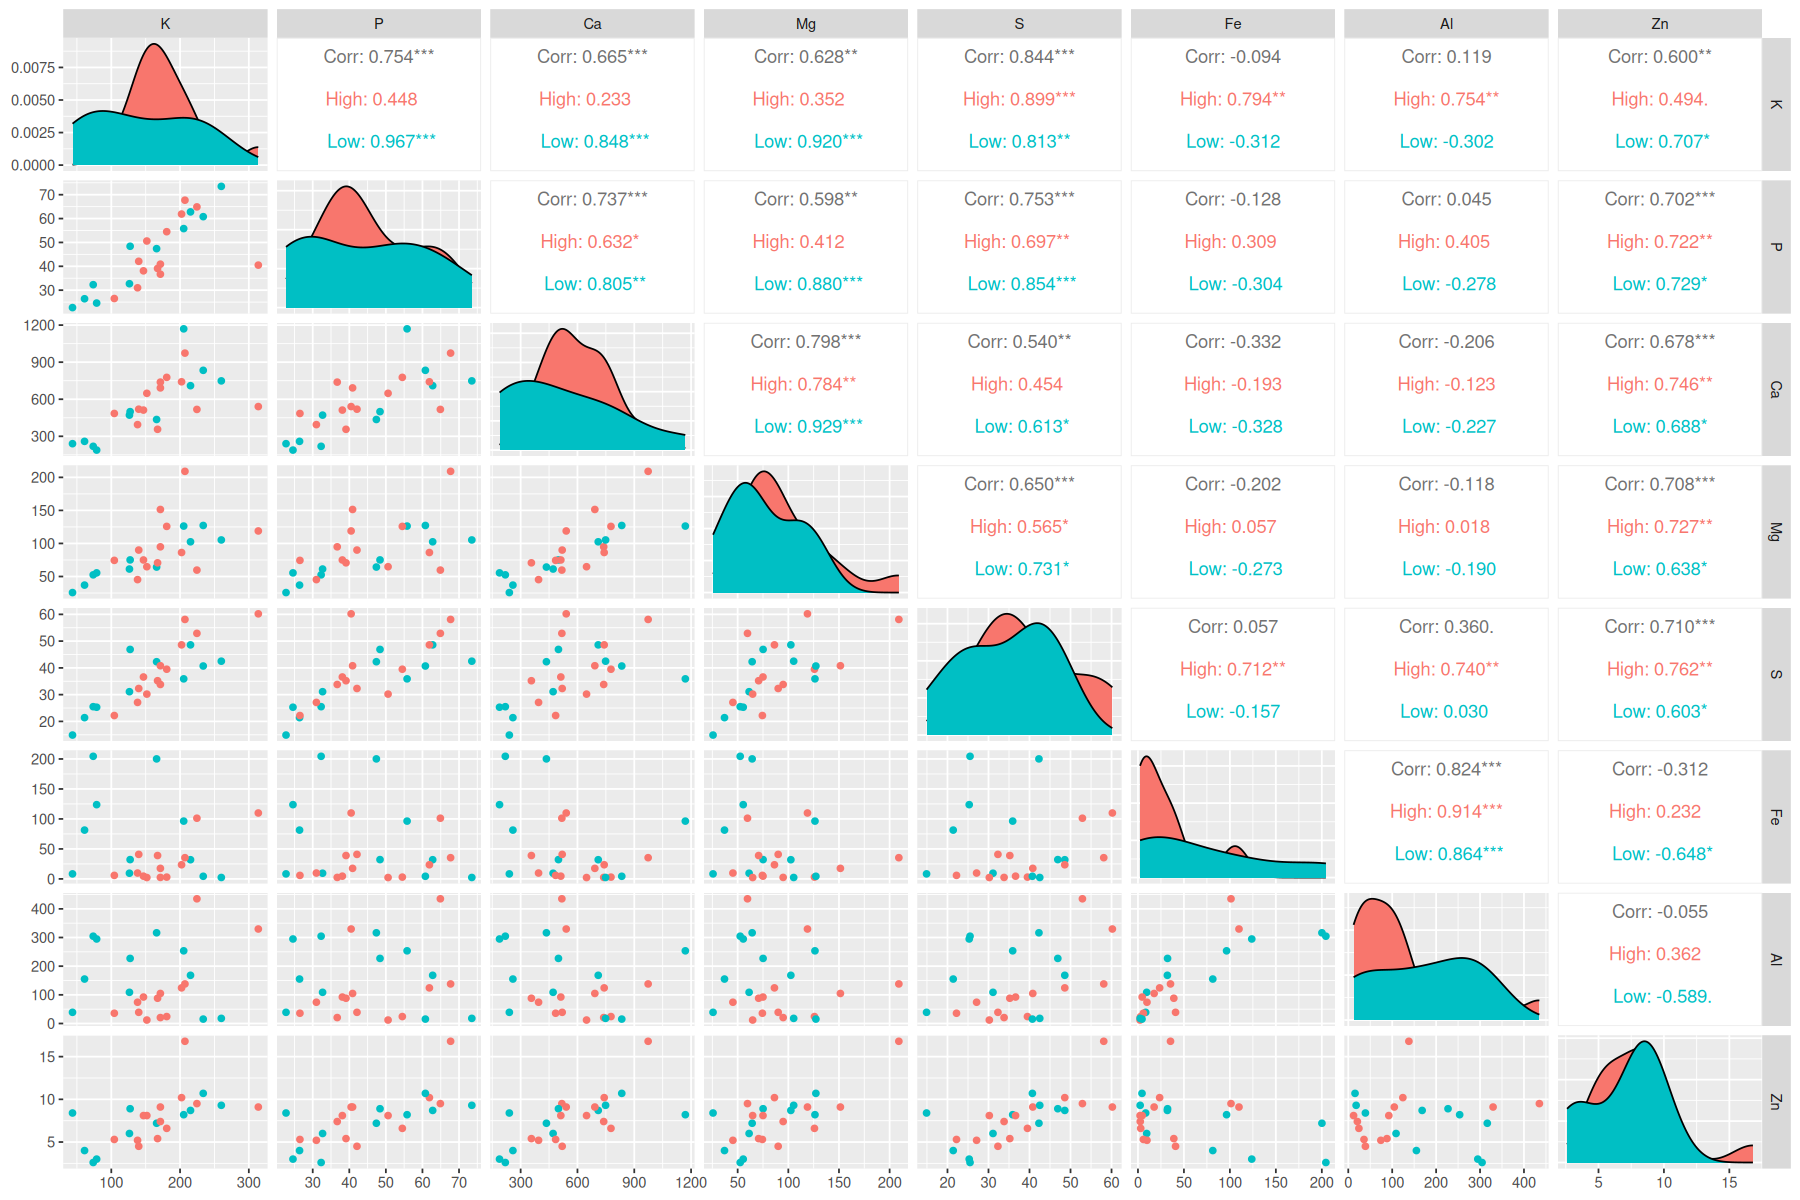

In [131]:
cor_matrix <- cor(df_numeric)
elementos <- c()
# Solo se recorre la triangular superior de la matriz de correlaciones.
for (row in 2:nrow(cor_matrix)){
    for (col in 1:(row - 1)){
        rho <- cor_matrix[row, col] # Coeficiente de correlacion lineal de Pearson
        if (rho^2 > 0.5 ){
            e1 <- rownames(cor_matrix)[row]; e2 <- colnames(cor_matrix)[col]
            elementos <- c(elementos, e1, e2)
        }
    }
}
elementos <- unique(elementos)
# Grafico
options(repr.plot.width=15, repr.plot.height=10)
ggpairs(df_vegetal[, elementos], 
        aes(color = df_vegetal$Baresoil),)

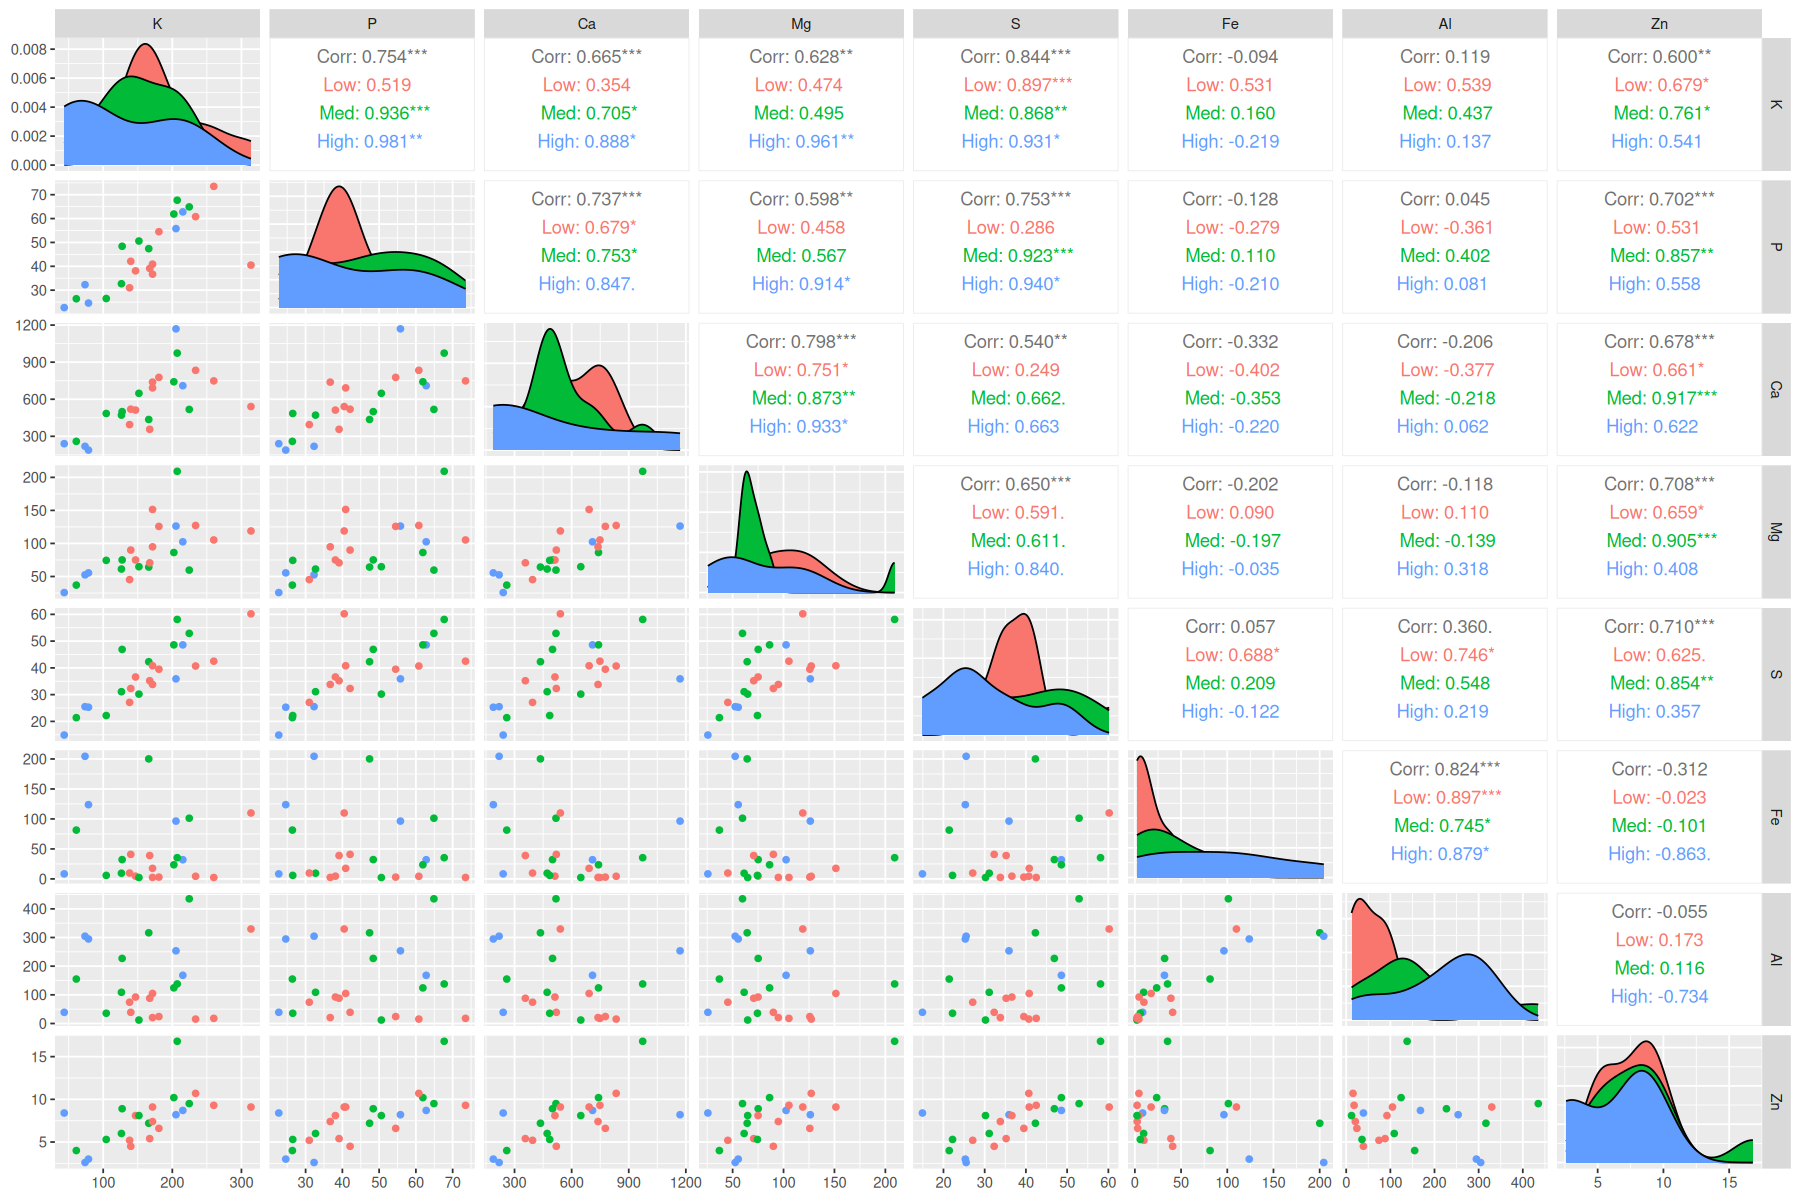

In [132]:
ggpairs(df_vegetal[, elementos], 
        aes(color = df_vegetal$pH))

 * Contenido de Potasio (K) vs Fósforo (P) medido en ppm:
    * Se puede observar que a medida que aumenta el contenido de fósforo, esto también ocurre para el potasio. No obstante, la parcela que mayor contenido en ppm tiene de ese último elemento químico no es aquel con mayor contenido en fósforo.
    * Entre las 7 parcelas que menor contenido tienen de estos elementos químicos, en su mayoría son de suelo desnudo bajo y poseen un pH medio y alto.
    * El comportamiento descrito en el primer punto se cumple fuertemente para las parcelas que poseen una cubierta de suelo desnudo baja ($\rho=0.967$).
    * A partir de estas 2 variables no se puede llegar a diferenciar una parcela con un cubierta de suelo desnudo baja de una alta.
* Contenido de Azufre (S) para las parcelas con una cubierta de suelo desnudo baja y nivel de ph alto:
    * Se observa que estas propiedades no definen el contenido de este elemento químico sobre una parcela, ya que se tiene registro de unas con una cantidad alta, mientras otras con una baja.
* Contenido de Zinc (Zn) según la cubierta de suelo desnudo y nivel de ph:
  * A través de sus gráficos de estimación de densidad de kernal para estas 2 variables cualitativas, se observa que estas dos características como tal no definen si una parcela tendrá o no una mayor contenido de este elemento químico, ya que los puntos se encuentran muy cercanos entre ellos.

---

Cuestión 2: ¿Hay una única solución del problema?
* No podemos afirmar que haya una única solución al problema. Primero de todo, viendo el dataframe podemos observar dos variables categóricas, 'Baresoil' y 'pH', que toman 2 y 3 valores distintos respectivamente. La clasificación de los datos podríamos basarla en función de estas dos variables, por lo que descartamos que haya una única solución.

Cuestión 3: ¿Variarı́a sustancialmente la solución si las variables se expresasen en otras unidades? ¿Cómo variarı́a, si es el caso?
* Si afectaría en la solución del problema. Por ejemplo, si algunos elementos químicos se midieran a una escala más grande que otros, entonces estos van a ser quienes a la hora de calcular las distancias entre las observaciones y esto puede llevar a la formación de diferentes conglomerados tras llevar a cabo el análisis clúster.

Cuestión 4: ¿Cuántos grupos se deberían considerar?
* Teniendo en cuenta los niveles o valores posibles que toman las variables "Baresoil" (high y low) y "pH" (high, med y low). Se puede plantear que a la hora de realizar el análisis clúster, se creen aproximadamente entre 2 y 3 conglomerados.

---

#### Apartado 5: Agrupación de parcelas considerando un método jerárquico

1. Calculo de la matriz de distancias: Tras haber realizado el análisis multivariante, nos hemos dado cuenta de que existen variables correlacionadas.
Con esto en mente, decidimos calcular la matriz de distancias teniendo en cuenta la distancia de Mahalanobis en vez de la distancia euclídea.

In [133]:
# Calculamos los parametros necesarios: Vector de medias y matriz varianzas-covarianzas
u_vector <- as.vector(colMeans(df_numeric))
var_cov <- cov(df_numeric)
# Creamos la matriz de distancias
dist_mahalanobis <- dist(mahalanobis(df_numeric, center = u_vector, cov=var_cov))

2. Creación de los clústers: Una vez tenemos la matriz de distancias, escogemos un criterio para la creacion de grupos. Dentro de los metodos jerarquicos, elegiremos entre: Encadenamiento simple, encadenamiento completo, método del promedio, método del centroide y metodo de Ward.

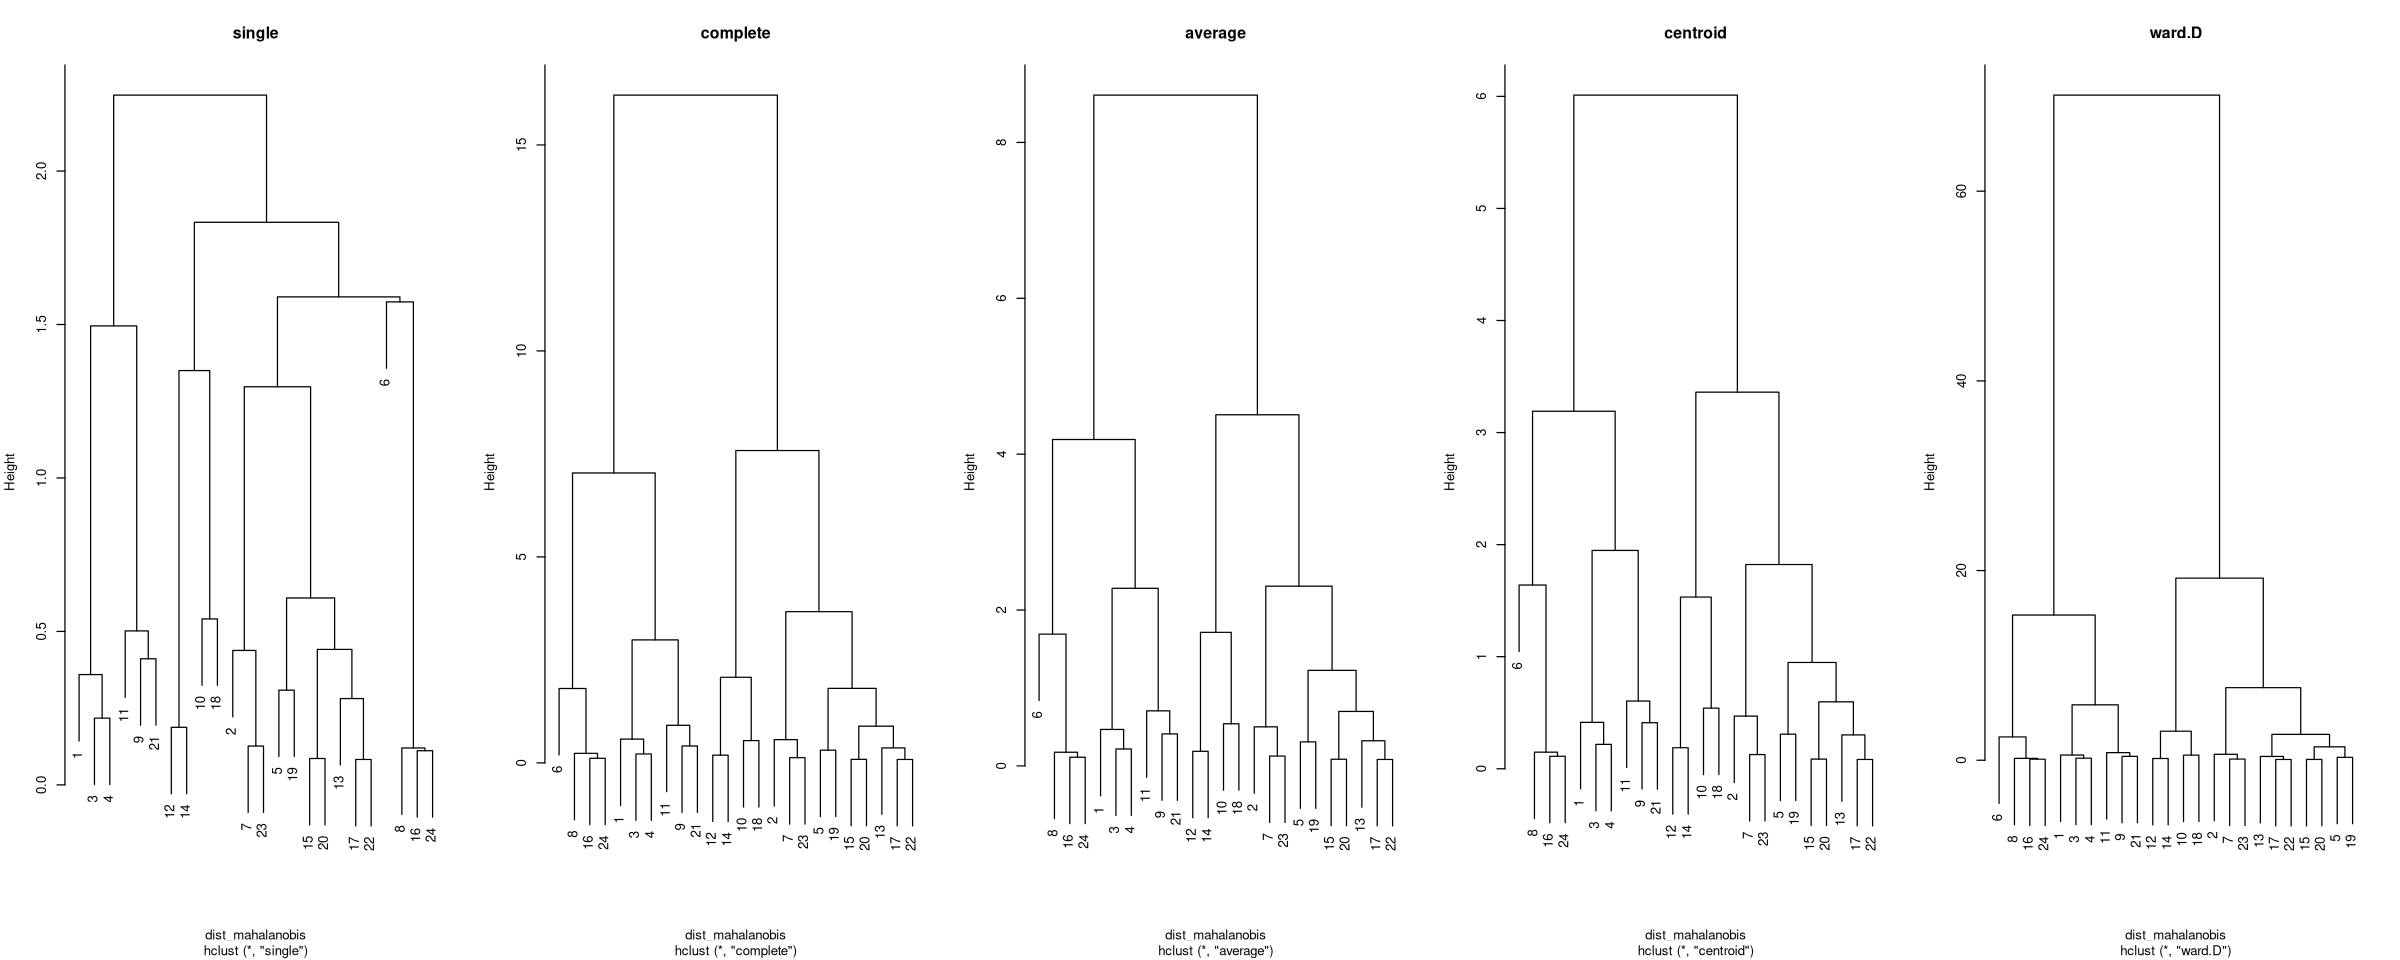

In [134]:
options(repr.plot.width=20, repr.plot.height=8)
par(mfrow = c(1, 5))
methods <- c("single", "complete", "average", "centroid", "ward.D")

for (i in 1:length(methods)){
    dendogram <- hclust(dist_mahalanobis, method = methods[i])
    plot(dendogram, main = methods[i])
}

Analizando los dendogramas, nos damos cuenta que, exceptuando con el encadenamiento simple, todos los dendogramas sugieren entre 2 o 4 grupos distintos, porque se observa que el número de miembros entre ellos resulta proporcional. 

En caso tomar cuatro grupos, la proporción de estos seria de 4, 6, 4, y 10. Además, se obtendría un buen punto de corte, es decir, uno que puede variar con libertad sin afectar el número de grupos. Sin embargo, de seleccionar dos grupos se puede obtener una mejor proporción entre ellos 10 y 14 y un punto de corte más estable.  Esto en un principio, nos puede hacer pensar que este número de grupos pueda estar asociado al número niveles que toma la variable categórica "Baresoil". Por ello, se tomó la decisión de formar 2 grupos.

Luego, entre los dendogramas impresos por pantalla; a pesar de que presentan una estructura similar,  decidimos optar por el del método de WARD, ya que este algoritmo en vez de tomar en cuenta la distancia entre individuos, calcula como cambia la varianza dentro de un conglomerado si se decide añadir un nuevo elemento. De esta manera, se preserva la propiedad de homogeneidad dentro de los clústers.

Cabe también resaltar, que el encadenamiento simple es el peor de todos para la formacion de 2 o 4 clústers. Pues, si intentamos hacer 4 grupos, queda un cluster de un único individuo, mientras que con 2, la proporción es muy mala, siendo dos clústers de 6 y  17 ndividuos, más del doble.
No obstante, de considerarse 3 grupos , se obtiene un punto de corte significativo y una buena proporcion de individuos entre clusters 6, 4 y 13, lo que podría dar estar relacionado a los niveles de pH.

---

##### Obteniendo los miembros de los 2 clústers



In [135]:
cluster <- hclust(dist_mahalanobis, method = 'ward.D')

#Tenemos dos formas de 'cortar' el arbol:
grupos <- cutree(cluster, NULL, 50)
#cutree(cluster, 2)

#Ya que sabemos que va a haber dos grupos, podemos elegir el punto de corte o decir cuantos grupos queremos

cluster_1 <- c()
cluster_2 <- c()
for (i in 1:length(grupos)){

    if (grupos[i] == 1)
        {  cluster_1 <- c(cluster_1, i)  }

    else
        {  cluster_2 <- c(cluster_2, i)  }
}

cat('Elementos del cluster 1: ', cluster_1)
cat('\nElementos del cluster 2: ', cluster_2)

Elementos del cluster 1:  1 3 4 6 8 9 11 16 21 24
Elementos del cluster 2:  2 5 7 10 12 13 14 15 17 18 19 20 22 23

Una vez obtenidos los elementos que pertenecen a cada clúster, procedemos a analizar los dos clústers:

In [177]:
#Filtramos el dataframe con las variables de cada uno de los clusters
df_cluster_1 <- df_numeric[cluster_1, ] 
df_cluster_2 <- df_numeric[cluster_2, ]
#Calculo de las medias del los clusters
mean_cluster_1 <- as.vector(t(stats_summary(df_cluster_1)[, 4]))
mean_cluster_2 <- as.vector(t(stats_summary(df_cluster_2)[, 4]))
#Calculo de la diferencia de medias
diff_cluster_mean <- mean_cluster_1 - mean_cluster_2
t(data.frame('Media Grupo 1' = mean_cluster_1, 
             'Media Grupo 2' = mean_cluster_2, 
             'Diferencia de medias' = diff_cluster_mean, 
             row.names = (colnames(df_numeric))))

,N,P,K,Ca,Mg,S,Al,Fe,Mn,Zn,Mo,Humdepth
Media.Grupo.1,23.58,50.08,188.55,621.63,101.87,42.15,209.77,72.72,41.91,8.93,0.41,1.93
Media.Grupo.2,21.53,41.51,144.63,532.54,77.16,33.65,94.41,33.11,54.63,6.64,0.39,2.39
Diferencia.de.medias,2.05,8.57,43.92,89.09,24.71,8.50,115.36,39.61,-12.72,2.29,0.02,-0.46


Se puede observar que las medias del grupo 1 son aproximadamente mayores que las del grupo 2, esto se puede a evidenciar a través de la diferencia de medias calculadas, donde se presencia una gran cantidad de números positivos. Aunque, se puede destacar que solo el Manganeso (Mn) y el Humdepth tienen una media mayor en el grupo 2.

In [178]:
# Cálculo de la distancia media entre clústers
dist_cluster_mean <- dist(rbind(mean_cluster_1, mean_cluster_2))
dist_cluster_mean

               mean_cluster_1
mean_cluster_2       160.2205

Una distancia de 160 es considerablemente grande, lo que puede indicar que hay una gran diferenciacion entre clústers.

--- 

#### Apartado 6: Agrupación de parcelas considerando un método no jerárquico

A continuación se hará uso del método k-medias y se estudiará como varía la varianza entre y dentro de los conglomerados para evaluar el número óptimo de grupos que se deberían formar.

1. Se aplica esta técnica para diferentes tamaños de $k = [2, n]$ y se resgistrar los siguientes atributos para cada uno de ellos:
   * $\text{tot.withinss}\rightarrow$ Estadístico que mide cúan dispersas estas las observaciones dentro de los clústeres.
   * $\text{betweenss}\rightarrow$ Variabilidad entre los clústers.

In [136]:
set.seed(246)

n <- nrow(df_numeric)
var_int <- c(); var_bet <- c()
for (i in 2:n){
    km <- kmeans(df_numeric, center=i, nstart=20, algorithm = "MacQueen")
    var_int <- c(var_int, km$tot.withinss); var_bet <- c(var_bet, km$betweenss)
}

2. A través del gráfico de sedimentación o del codo, se estudia a partir de qué $k$ estos atributos convergen.

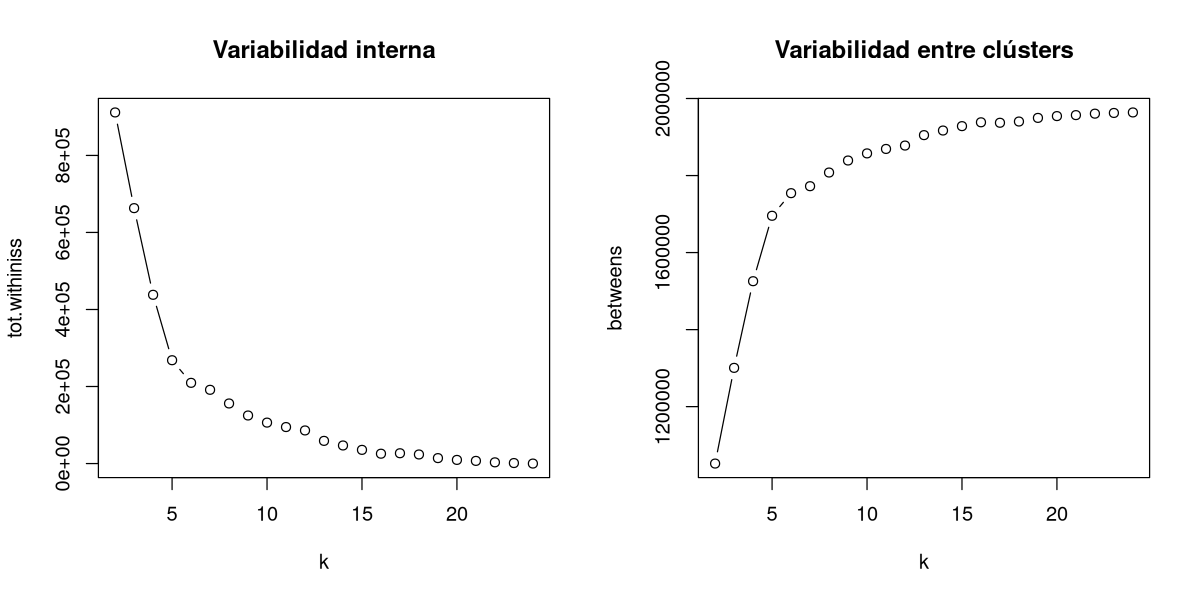

In [137]:
options(repr.plot.width=10, repr.plot.height=5)
par(mfrow=c(1, 2))
plot(2:n, var_int, type = "b", ylab="tot.withiniss", xlab="k", main = "Variabilidad interna")
plot(2:n, var_bet, type = "b", ylab="betweens", xlab="k", main = "Variabilidad entre clústers")

A través de estos gráficos de sedimentación, tanto la variabilidad interna como la que existe entre los conglomerados deja de decrecer y aumentar de manera significativa, respectivamente, una vez el parámetro $k$ toma el valor de 5; por lo tanto, este resulta un número óptimo de grupos.   

In [157]:
# Conocer las parcelas que integran los 5 clusters
set.seed(123)

km <- kmeans(df_numeric, center = 5, nstart = 20, algorithm = "MacQueen")
for (i in 1:5){
    parcelas <- which(km$cluster == i)
    cat("Parcelas que pertenecen al", paste0("G", i, ":"), parcelas, paste0("(", length(parcelas), " miembros)"),"\n")
}

Parcelas que pertenecen al G1: 1 3 11 (3 miembros) 
Parcelas que pertenecen al G2: 9 21 (2 miembros) 
Parcelas que pertenecen al G3: 7 10 12 13 14 15 18 (7 miembros) 
Parcelas que pertenecen al G4: 2 4 5 6 (4 miembros) 
Parcelas que pertenecen al G5: 8 16 17 19 20 22 23 24 (8 miembros) 


In [175]:
# Medias de las variables por cada cluster 
means_clusters <- km$centers
row.names(means_clusters) <- sapply(1:5, function(i) paste0("G", i) )
means_clusters

,N,P,K,Ca,Mg,S,Al,Fe,Mn,Zn,Mo,Humdepth
G1,22.80000,50.93333,234.7333,498.1333,80.96667,51.80000,360.43333,137.06667,42.63333,8.6000,0.6333333,1.833333
G2,18.45000,61.75000,206.2000,1071.5000,167.70000,47.00000,195.80000,65.90000,28.60000,12.5000,0.4250000,1.550000
G3,18.74286,36.84286,135.7714,462.6714,70.25714,33.05714,95.04286,20.27143,36.12857,6.2000,0.3857143,2.285714
G4,28.45000,26.50000,64.2750,226.7250,42.67500,21.77500,198.40000,104.50000,17.92500,4.5000,0.4250000,1.600000
G5,23.36250,55.21250,198.2750,736.1125,107.27500,40.58750,60.95000,10.97500,84.27500,8.7625,0.2937500,2.725000


A través de esta matriz se puede observar lo siguiente:
* El G2 está compuesto por aquellas parcelas que en media poseen el mayor contenido de Calcio. Y como este elemento químico está altamente correlacionado con el Magnesio ($\rho \approx 0.8$) según la matriz de correlaciones expuesta en el análisis multivariante, esto trae como consecuencia que también pertenezcan aquellas parcelas que posee un alto contenido en ppm para este elemento.
* El grosor de la capa de humus (Humpdepth) no varía de manera significativa entre clústers. 